In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

#데이터 시각화 패키지
import seaborn as sns

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

from datetime import datetime


#ignore warnings
import warnings
warnings.filterwarnings('ignore')

matplotlib.rc('font',family = 'NanumGothicCoding')

In [26]:
df_raw = pd.read_csv("./data/환율.csv", encoding = '949', parse_dates = ['APPL_DATE'])
df_raw.head()

,CURRENCY,APPL_DATE,STD_RATE,USD_CONV_DATE
0,CNY,2016-01-01,181.48,0.1541
1,JPY,2016-01-01,976.99,0.8294
2,USD,2016-01-01,1178.00,1.0000
3,CNY,2016-01-02,181.48,0.1541
4,JPY,2016-01-02,976.99,0.8294


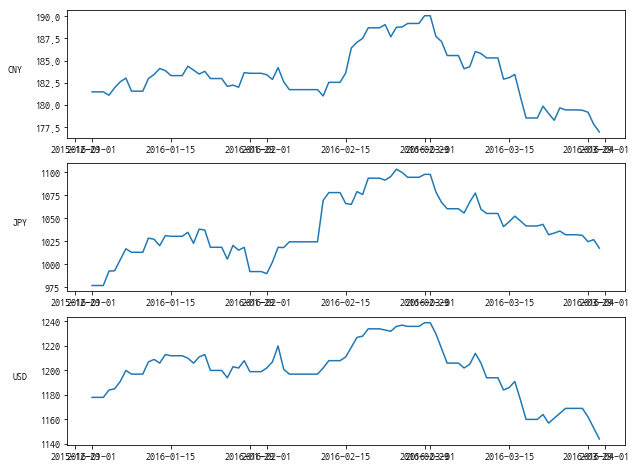

In [27]:
#중국 위엔화, 엔화, 달러의 크리가 다르기 때문에 각각 그래프 생성
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize=(10,8))

for(ax, idx, currency) in zip([ax1, ax2, ax3],[311,312,313],['CNY','JPY','USD']):
    ax.plot('APPL_DATE', 'STD_RATE', data = df_raw[df_raw['CURRENCY'] == currency])
    ax.set_ylabel(currency, rotation = 0, labelpad = 20)

In [28]:
df_CNY = df_raw[df_raw['CURRENCY'] == 'CNY'].set_index('APPL_DATE')
df_CNY.drop(['CURRENCY', 'USD_CONV_DATE'], axis = 1, inplace = True)

df_JPY = df_raw[df_raw['CURRENCY'] == 'JPY'].set_index('APPL_DATE')
df_JPY.drop(['CURRENCY', 'USD_CONV_DATE'], axis = 1, inplace = True)

df_USD = df_raw[df_raw['CURRENCY'] == 'USD'].set_index('APPL_DATE')
df_USD.drop(['CURRENCY', 'USD_CONV_DATE'], axis = 1, inplace = True)

df_CNY.head()

,STD_RATE
APPL_DATE,
2016-01-01,181.48
2016-01-02,181.48
2016-01-03,181.48
2016-01-04,181.10
2016-01-05,181.94


## train & test data 분할 : 비율 기준 mask 지정

In [29]:
train_size = 0.9
len_idx = len(df_CNY.index)
mask = (np.arange(len_idx)/len_idx) < train_size
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False])

## 데이터 분할

In [30]:
df_CNY_train = df_CNY[mask]
df_CNY_test = df_CNY[~mask]

print('shape of train date : {}'.format(df_CNY_train.shape))
print('shape of test date : {}'.format(df_CNY_test.shape))

shape of train date : (82, 1)
shape of test date : (9, 1)


In [31]:
df_CNY_train = df_CNY[df_CNY.index <= '2016-03-22']
df_CNY_test = df_CNY[df_CNY.index > '2016-03-22']
df_CNY_test.head()

,STD_RATE
APPL_DATE,
2016-03-23,178.28
2016-03-24,179.68
2016-03-25,179.45
2016-03-26,179.45
2016-03-27,179.45


## 시계열 분석

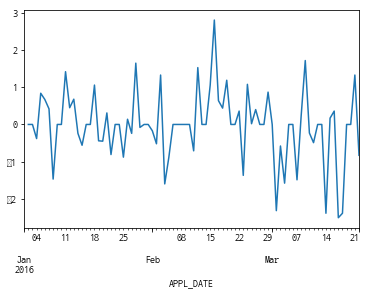

In [32]:
df_CNY_diff1 = df_CNY_train['STD_RATE'] - df_CNY_train['STD_RATE'].shift(1)
df_CNY_diff1.plot()

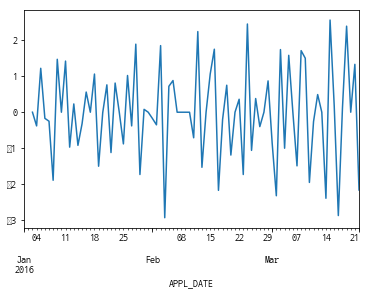

In [33]:
df_CNY_diff2 = df_CNY_train['STD_RATE'] - 2*(df_CNY_train['STD_RATE'].shift(1)) + (df_CNY_train['STD_RATE'].shift(2))
df_CNY_diff2.plot()

## 시계열 분석 - 자기상관 함수 및 부분 자기상관 함수

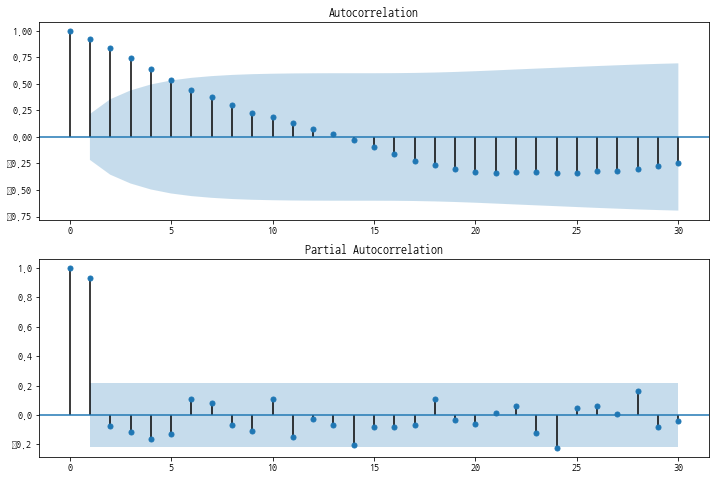

In [36]:
lag_size = 30
fig = plt.figure(figsize = (12,8))

ax1 = fig.add_subplot(211)
fig = plot_acf(df_CNY_train['STD_RATE'], lags = lag_size, ax = ax1)

ax2 = fig.add_subplot(212)
fig = plot_pacf(df_CNY_train['STD_RATE'], lags = lag_size, ax = ax2)

> AFC가 감소하며, PACF가 2시점에서 절단면을 갖는다면, 1시점 전의 자료가 현재에 영향을 미침

## 시계열 분석

In [37]:
ts_model_cny = ARIMA(df_CNY_train, order = (1,2,0))

ts_result_cny = ts_model_cny.fit(trend = 'c', full_output = True, disp = 1)
print(ts_result_cny.summary())

                             ARIMA Model Results                              
Dep. Variable:            D2.STD_RATE   No. Observations:                   80
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -123.512
Method:                       css-mle   S.D. of innovations              1.132
Date:                Thu, 02 May 2019   AIC                            253.025
Time:                        14:23:38   BIC                            260.171
Sample:                    01-03-2016   HQIC                           255.890
                         - 03-22-2016                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0022      0.088     -0.024      0.981      -0.175       0.171
ar.L1.D2.STD_RATE    -0.4389      0.102     -4.322      0.000      -0.638      -0.240
                        

> ARIMA(1,2,0) 모델 유의성 확인

## 예측 및 결과 해석

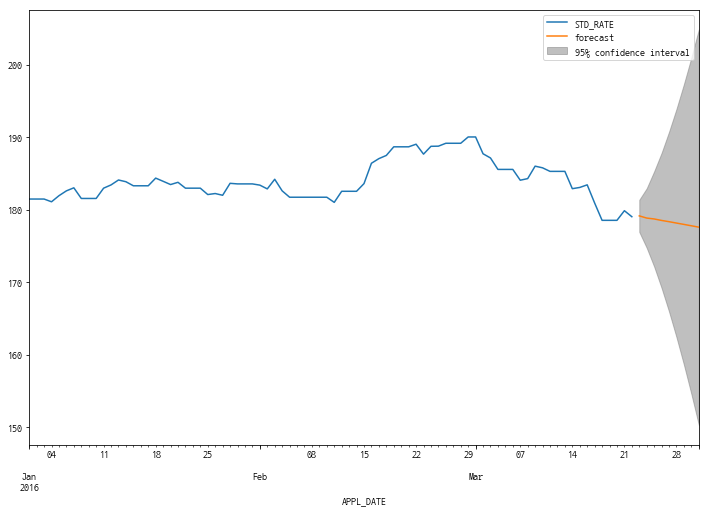

In [39]:
start_time = df_CNY_test.index.min()
end_time = df_CNY_test.index.max()
fig, ax = plt.subplots(figsize=(12,8))

ax = df_CNY_train.plot(ax = ax)
fig = ts_result_cny.plot_predict(start=start_time, end=end_time, ax = ax, plot_insample = False)

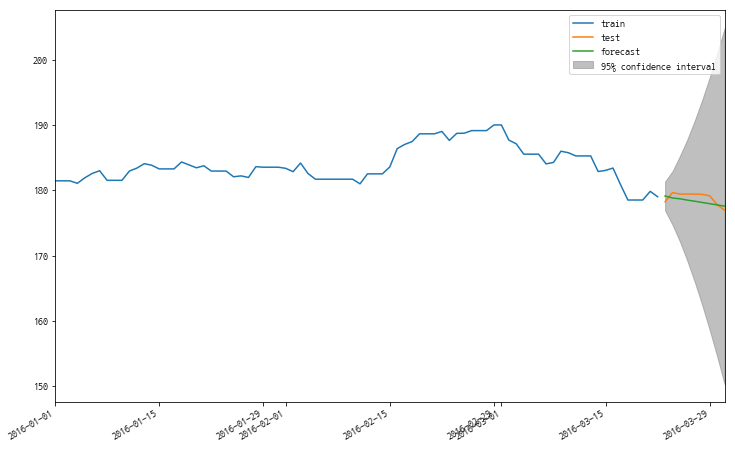

In [41]:
start_time = df_CNY_test.index.min()
end_time = df_CNY_test.index.max()
fig, ax = plt.subplots(figsize = (12,8))
plt.plot(df_CNY_train, linestyle = '-', label='train')
plt.plot(df_CNY_test, linestyle = '-', label='test')

fig = ts_result_cny.plot_predict(start=start_time, end = end_time, ax=ax, plot_insample=False)